In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
print(os.listdir("../input/digit-recognizer"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [40]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary

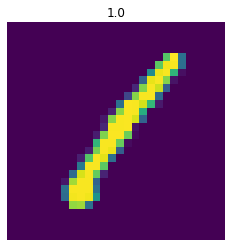

In [3]:
# load data
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype=np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255

# train test split
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size=0.2,
                                                                             random_state=42)

# create feature and targets tensor for train set
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

# batch size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[0].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[0]))
plt.savefig('graph.png')
plt.show()

In [49]:
print(int(11/2))

5


In [58]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        
#         # Max pool 3
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(64 * 3 * 3, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
#         # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        
#         # Max pool 3
#         out = self.maxpool3(out)

        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out


In [59]:
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)


train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


model = CNNModel()

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           4,640
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          18,496
              ReLU-8             [-1, 64, 3, 3]               0
            Linear-9                   [-1, 10]           5,770
Total params: 29,066
Trainable params: 29,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.11
Estimated Total Size (MB): 0.37
---------------------------------------------

In [60]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    train = Variable(images.view(100,1,28,28))
    print(train.shape)
    print(labels.shape)
    labels = Variable(labels)
    print(labels.shape)
    break

torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([100])


In [62]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
# for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.07136430591344833  Accuracy: 97.17857360839844 %
Iteration: 1000  Loss: 0.03848724067211151  Accuracy: 97.86904907226562 %
Iteration: 1500  Loss: 0.022948170080780983  Accuracy: 97.76190185546875 %
Iteration: 2000  Loss: 0.012958464212715626  Accuracy: 98.19047546386719 %


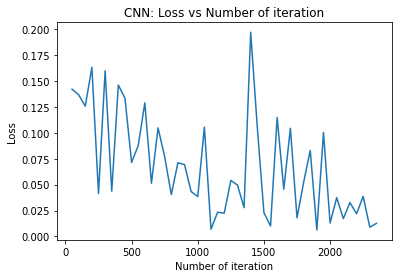

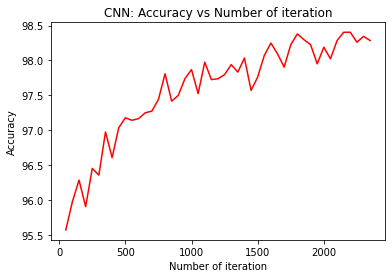

In [63]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [64]:
#save model
print('save model state dict keys: \n', model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

save model state dict keys: 
 odict_keys(['cnn1.weight', 'cnn1.bias', 'cnn2.weight', 'cnn2.bias', 'cnn3.weight', 'cnn3.bias', 'fc1.weight', 'fc1.bias'])


In [65]:
# load model
state_dict = torch.load('checkpoint.pth')
print('load model state dict keys: \n', model.state_dict().keys())

load model state dict keys: 
 odict_keys(['cnn1.weight', 'cnn1.bias', 'cnn2.weight', 'cnn2.bias', 'cnn3.weight', 'cnn3.bias', 'fc1.weight', 'fc1.bias'])


In [66]:
# load test data
new_test = pd.read_csv('../input/digit-recognizer/test.csv').values
new_images = torch.from_numpy(new_test).type(torch.FloatTensor)/255
print(new_images.shape)
new_test_loader = DataLoader(new_images, batch_size=batch_size, shuffle=False)

torch.Size([28000, 784])


In [67]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        images = Variable(images.view(batch_size,1,28,28))
        outputs = model(images)
        predict = torch.max(outputs.data, 1)[1]
        results += predict.numpy().tolist()
        
print(results[:10])
print(len(results))

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]
28000


In [68]:
results = np.array(results).flatten()
print(results[:10])
print(results.shape)

[2 0 9 9 3 7 0 3 0 3]
(28000,)


In [69]:
submission = pd.DataFrame({'ImageId': list(range(1, len(results)+1)),
                          'Label': results})
submission.to_csv('submission.csv',index=False, header=True)
print(submission[:10])

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3
